### ニューラルネットワークにおける単語の処理方法

In [1]:
from common.layers import MatMul

In [2]:
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

In [3]:
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

In [4]:
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

In [5]:
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

In [6]:
s

array([[ 0.61678211, -1.78517647, -0.08519479, -2.88450797, -0.78777084,
        -0.03756353, -1.48863795]])

### コンテキストとターゲット

In [7]:
from common.util import preprocess

In [8]:
text = "You say goodbye and I say hello."

In [9]:
corpus, word_to_id, id_to_word = preprocess(text)

In [10]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [11]:
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [12]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [13]:
contexts, target = create_contexts_target(corpus, window_size=1)

In [14]:
contexts

array([[0, 2],
       [1, 3],
       [2, 4],
       [3, 1],
       [4, 5],
       [1, 6]])

In [15]:
target

array([1, 2, 3, 4, 1, 5])

### one-hot表現への変換

In [16]:
from common.util import preprocess, create_contexts_target, convert_one_hot

In [17]:
text = "You say goodbye and I say hello."

In [18]:
corpus, word_to_id, id_to_word = preprocess(text)

In [19]:
contexts, target = create_contexts_target(corpus, window_size=1)

In [20]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [21]:
target

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [22]:
contexts

array([[[1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]],

       [[0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1]]], dtype=int32)

### CBOWモデルの実装

In [23]:
from common.layers import MatMul, SoftmaxWithLoss

In [24]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out) 
        self.loss_layer = SoftmaxWithLoss()
        
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

### 学習コードの実装

In [25]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot

In [26]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

In [27]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [28]:
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [29]:
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

| epoch 287 |  iter 1 / 2 | time 0[s] | loss 1.03
| epoch 288 |  iter 1 / 2 | time 0[s] | loss 1.01
| epoch 289 |  iter 1 / 2 | time 0[s] | loss 0.92
| epoch 290 |  iter 1 / 2 | time 0[s] | loss 1.00
| epoch 291 |  iter 1 / 2 | time 0[s] | loss 1.08
| epoch 292 |  iter 1 / 2 | time 0[s] | loss 0.93
| epoch 293 |  iter 1 / 2 | time 0[s] | loss 1.01
| epoch 294 |  iter 1 / 2 | time 0[s] | loss 0.95
| epoch 295 |  iter 1 / 2 | time 0[s] | loss 0.94
| epoch 296 |  iter 1 / 2 | time 0[s] | loss 0.97
| epoch 297 |  iter 1 / 2 | time 0[s] | loss 1.07
| epoch 298 |  iter 1 / 2 | time 0[s] | loss 1.00
| epoch 299 |  iter 1 / 2 | time 0[s] | loss 1.04
| epoch 300 |  iter 1 / 2 | time 0[s] | loss 0.93
| epoch 301 |  iter 1 / 2 | time 0[s] | loss 1.06
| epoch 302 |  iter 1 / 2 | time 0[s] | loss 0.98
| epoch 303 |  iter 1 / 2 | time 0[s] | loss 0.82
| epoch 304 |  iter 1 / 2 | time 0[s] | loss 1.04
| epoch 305 |  iter 1 / 2 | time 0[s] | loss 1.05
| epoch 306 |  iter 1 / 2 | time 0[s] | loss 0.79


| epoch 565 |  iter 1 / 2 | time 0[s] | loss 0.73
| epoch 566 |  iter 1 / 2 | time 0[s] | loss 0.60
| epoch 567 |  iter 1 / 2 | time 0[s] | loss 0.83
| epoch 568 |  iter 1 / 2 | time 0[s] | loss 0.73
| epoch 569 |  iter 1 / 2 | time 0[s] | loss 0.43
| epoch 570 |  iter 1 / 2 | time 0[s] | loss 0.80
| epoch 571 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 572 |  iter 1 / 2 | time 0[s] | loss 0.66
| epoch 573 |  iter 1 / 2 | time 0[s] | loss 0.73
| epoch 574 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 575 |  iter 1 / 2 | time 0[s] | loss 0.66
| epoch 576 |  iter 1 / 2 | time 0[s] | loss 0.57
| epoch 577 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 578 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 579 |  iter 1 / 2 | time 0[s] | loss 0.66
| epoch 580 |  iter 1 / 2 | time 0[s] | loss 0.72
| epoch 581 |  iter 1 / 2 | time 0[s] | loss 0.63
| epoch 582 |  iter 1 / 2 | time 0[s] | loss 0.86
| epoch 583 |  iter 1 / 2 | time 0[s] | loss 0.36
| epoch 584 |  iter 1 / 2 | time 0[s] | loss 0.89


| epoch 845 |  iter 1 / 2 | time 0[s] | loss 0.70
| epoch 846 |  iter 1 / 2 | time 0[s] | loss 0.37
| epoch 847 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 848 |  iter 1 / 2 | time 0[s] | loss 0.57
| epoch 849 |  iter 1 / 2 | time 0[s] | loss 0.55
| epoch 850 |  iter 1 / 2 | time 0[s] | loss 0.50
| epoch 851 |  iter 1 / 2 | time 0[s] | loss 0.70
| epoch 852 |  iter 1 / 2 | time 0[s] | loss 0.52
| epoch 853 |  iter 1 / 2 | time 0[s] | loss 0.57
| epoch 854 |  iter 1 / 2 | time 0[s] | loss 0.50
| epoch 855 |  iter 1 / 2 | time 0[s] | loss 0.63
| epoch 856 |  iter 1 / 2 | time 0[s] | loss 0.55
| epoch 857 |  iter 1 / 2 | time 0[s] | loss 0.51
| epoch 858 |  iter 1 / 2 | time 0[s] | loss 0.51
| epoch 859 |  iter 1 / 2 | time 0[s] | loss 0.81
| epoch 860 |  iter 1 / 2 | time 0[s] | loss 0.32
| epoch 861 |  iter 1 / 2 | time 0[s] | loss 0.67
| epoch 862 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 863 |  iter 1 / 2 | time 0[s] | loss 0.67
| epoch 864 |  iter 1 / 2 | time 0[s] | loss 0.32


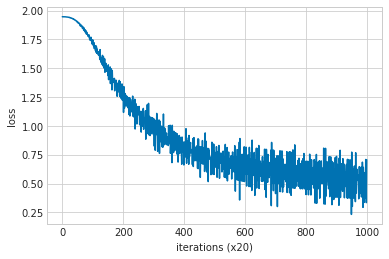

In [30]:
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [31]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 1.1091368 -1.5058678  1.0602204  1.0037001 -1.1689156]
say [-1.251749    0.71427536 -1.2572464  -1.1708678  -0.04915241]
goodbye [ 0.83080286 -0.23506206  0.9552312   1.1224648  -0.8076333 ]
and [-1.0006784  1.5311248 -0.968157  -1.0546081  1.5941788]
i [ 0.82415634 -0.23182958  0.91645265  1.102783   -0.77992594]
hello [ 1.1188836 -1.5218772  1.0624154  0.9979849 -1.1782556]
. [-1.119651  -1.6730044 -1.1248013 -0.9832714 -1.4737043]
